In [4]:
import numpy as np
import pandas as pd

city = "small"

edgelist = pd.read_csv("out/" + city + ".results.csv")
edgelist.head()

,edge_id,edge_from,edge_to,edge_length,edge_numLanes,edge_speed,flow,vehicle_speed
0,0,1614922744,1614922747,23.141939,2,29.0576,0.0,0.00
1,1,269459339,269459341,60.826398,5,29.0576,14274.0,25.65
2,2,1621320618,1621320622,109.464966,2,29.0576,1149.0,27.70
3,3,269459229,269459230,160.720645,3,29.0576,7974.0,25.03
4,4,607954833,1613371666,173.017706,3,29.0576,6504.0,26.02


In [5]:
import networkx as nx

G_undirected = nx.from_pandas_edgelist(edgelist, source="edge_from", target="edge_to", edge_attr=["edge_id", "edge_numLanes", "edge_speed",
                                                                                      "flow", "vehicle_speed"])
H = nx.line_graph(G_undirected)
H.add_nodes_from((node, G_undirected.edges[node]) for node in H)

def smoothness(H, attr):
    L = nx.laplacian_matrix(H)
    x = np.array([attrs[attr] for _, attrs in H.nodes(data=True)])
    return x.transpose() @ L @ x

smoothness(H, "vehicle_speed") / H.number_of_nodes()

14.352409075907591

In [6]:
smoothness(H, "flow") / H.number_of_nodes()

8887190.131188119

In [7]:
def fix_sensors(x, x_hat, sensors, attr):
    for s in sensors:
        try:
            x_hat[s] = x[s]
        except IndexError:
            print(type(s), s)

def predict(x, P, max_iter, sensors, attr): 
    x_hat = np.zeros(len(x))
    fix_sensors(x, x_hat, sensors, attr)        
    
    for t in range(max_iter):
        x_hat = P @ x_hat
        fix_sensors(x, x_hat, sensors, attr)
    
    return x_hat

In [28]:
from tqdm.notebook import tqdm
from multiprocess import Pool 
from itertools import repeat
import heapq

def choose_sensors(H, attr, k=None):    
    if k == None:
        k = int(H.number_of_nodes() / 50)
    
    # Convert node labels to 1,...,n
    node2idx = dict(zip(list(H.nodes()), range(H.number_of_nodes())))
    H = nx.relabel_nodes(H, node2idx)

    D = np.zeros((H.number_of_nodes(), H.number_of_nodes())) # Degree matrix
    x = np.zeros(H.number_of_nodes()) # True values
    for i, v in enumerate(H.nodes(data=True)):
        D[i][i] = H.degree[v[0]]
        x[i] = v[1][attr]
        
    P = np.linalg.inv(D) @ nx.adjacency_matrix(H)
    L = nx.laplacian_matrix(H)
    
    def evaluate(v, sensors):
        if v in sensors:
            return float("inf")

        pred = predict(x, P, 1000, sensors.union([v]), attr)    
        return (np.square(pred - x)).mean()
    
    sensors = set()
        
    # Find value of adding each node not in the set
    with Pool(1) as pool:
        deltas = pool.map(lambda v: (np.square(x - np.full(H.number_of_nodes(), x[v])).mean(), v), range(H.number_of_nodes()))
        heapq.heapify(deltas)
    
    for i in tqdm(range(k)):
        
        # Lazy evaluation: recompute the top unchosen node and place it in the queue
        # Recompute everything above that node
        current = (np.square(x - predict(x, P, 1000, sensors, attr))).mean()
        print("current", current)
        
        # Current top 
        _, s = heapq.heappop(deltas)
        delta = current - evaluate(s, sensors) 
        print("delta", delta)
        
        # Next top
        delta_next, s_next = heapq.heappop(deltas)
        print("delta_next", delta_next)
    
        # Compute change in top node
        # If the change drops it below the next best, recalculate the next best and continue
        while delta > delta_next:
            delta_next = current - evaluate(s_next, sensors)
            if delta_next < delta:
                delta, s = delta_next, s_next
                heapq.heappush(deltas, (delta, s))
            else:
                heapq.heappush(deltas, (delta_next, s_next))
            delta_next, s_next = heapq.heappop(deltas)
        
        sensors.add(s)
        
    idx2node = {v: k for k, v in node2idx.items()}
    return set([idx2node[s] for s in sensors]), predict(x, P, 1000, sensors, attr), idx2node

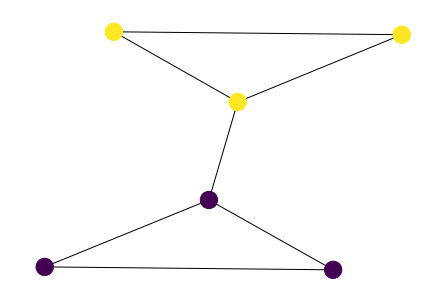

In [26]:
J = nx.Graph()
J.add_node(0, speed=5)
J.add_node(1, speed=5)
J.add_node(2, speed=5)

J.add_node(3, speed=10)
J.add_node(4, speed=10)
J.add_node(5, speed=10)

J.add_edges_from([(0, 1), (1, 2), (2, 0), (2, 3), (3, 4), (4, 5), (3, 5)])
nx.draw(J, node_color=[data["speed"] for _, data in J.nodes(data=True)])

In [29]:
s, p, d = choose_sensors(J, "speed", 2)
print(s)

  0%|          | 0/2 [00:00<?, ?it/s]

current 62.5
delta 49.999999999999964
delta_next 12.5
current 12.500000000000034
delta 1.7763568394002505e-14
delta_next 50.000000000000036
{0, 2}


In [30]:
opt_sensors, pred, idx2node = choose_sensors(H, "vehicle_speed", 43)

  0%|          | 0/43 [00:00<?, ?it/s]

current 689.2777609735974
delta 36.76268948933864
delta_next 49.7417345709571
current 652.5150714842588
delta 66.64649405306955
delta_next 49.74177252475248
current 622.7504735213076
delta 55.15061378201699
delta_next 49.744058663366324
current 585.613789323611
delta 28.190110086834466
delta_next 49.74642070957095
current 557.4236792367765
delta 1.8755680380280637
delta_next 49.74668638613862
current 555.5481111987484
delta -0.16877207424704466
delta_next 49.74668638613862
current 555.7168832729955
delta 39.08636126811507
delta_next 49.74790173267327
current 516.6305220048804
delta 92.54157390387957
delta_next 49.74992433993399
current 516.4556054170185
delta 47.88167792095203
delta_next 49.75396229372938
current 468.5739274960665
delta -0.08013247768536758
delta_next 49.7558258250825
current 468.6540599737519
delta 63.91808653640908
delta_next 49.758800247524746
current 446.00228649157
delta 0.6793377830519489
delta_next 49.761519224422436
current 445.322948708518
delta 75.15869673956

In [31]:
nodes = pd.read_csv("out/" + city + ".nodes.csv", sep=";").set_index("node_id")
nodes.head()

,node_x,node_y
node_id,,
269459457,-118.215300,34.056067
317640716,-118.221778,34.036254
317640717,-118.221770,34.036083
317640718,-118.221753,34.035806
317640719,-118.221718,34.035521


In [32]:
import matplotlib as mpl
import matplotlib.pyplot as plt

positions = {v: (k["node_x"], k["node_y"]) for v, k in nodes.to_dict("index").items()}
cmap = mpl.colormaps["viridis"]

G = nx.from_pandas_edgelist(edgelist, source="edge_from", target="edge_to", edge_attr=["edge_id", "edge_numLanes", "edge_speed",
                                                                                      "flow", "vehicle_speed"],
                           create_using=nx.DiGraph)
G.number_of_edges()

1220

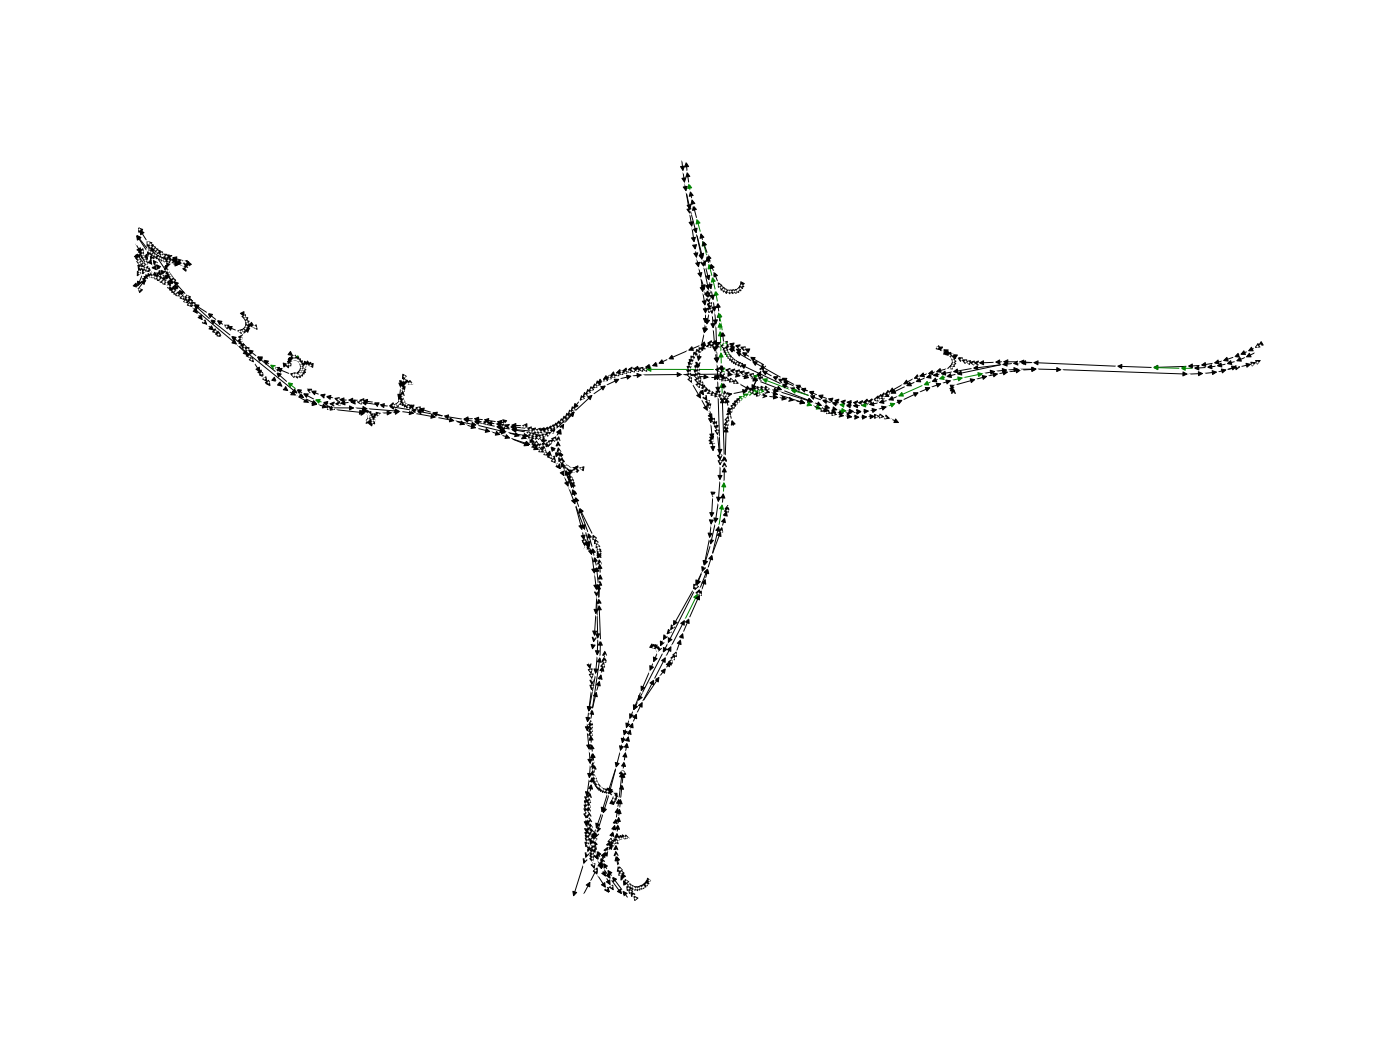

In [33]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])

edge_colors = ["green" if (u, v) in opt_sensors or (v, u) in opt_sensors else "black" for u, v in G.edges()]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)

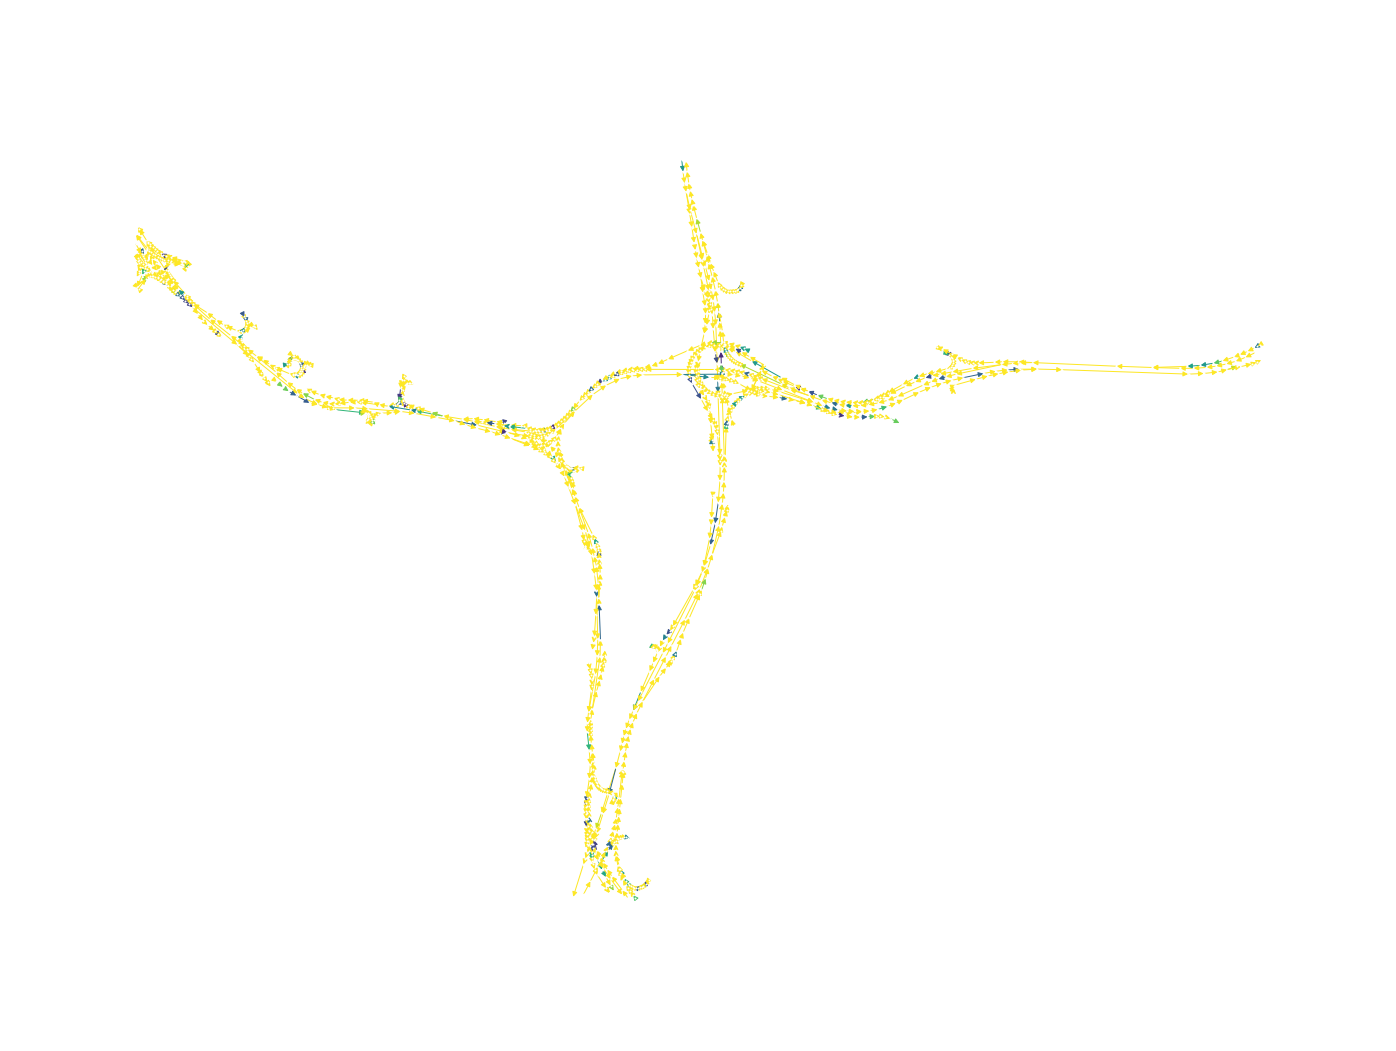

In [34]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])

nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=[cmap(p) for p in pred])